In [1]:
from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from models import Generator, Discriminator

%load_ext autoreload
%autoreload 2

In [2]:
dataroot = "../data/era_interim/*.nc"
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

target = '10UV_GDS4_SFC'
uncropped = xr.open_mfdataset(glob.glob(dataroot), combine='by_coords')
uncropped[target] = xr.ufuncs.hypot(uncropped['10U_GDS4_SFC'], uncropped['10V_GDS4_SFC'])
xarr = uncropped[target][:30, ...]
xarr = xr_standardize_field(xarr)

In [3]:
assert np.abs(xr_standardize_field(xarr).mean()) < 10E-5
assert np.abs(xr_standardize_field(xarr).std() - 1.0) < 10E-5

In [4]:
midx = uncropped['10UV_GDS4_SFC'].values.shape[2] // 2
midy = uncropped['10UV_GDS4_SFC'].values.shape[1] // 2
assert midx >= 2*midy

In [5]:
fine = uncropped['10UV_GDS4_SFC'][:, :, midx-midy:midx+midy]

In [6]:
sx, sy = 4, 4
coarse = fine.coarsen(g4_lon_2=sx).mean().coarsen(g4_lat_1=sy).mean()

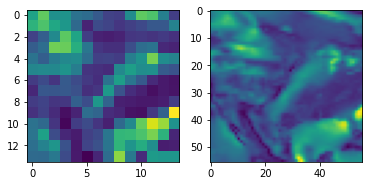

In [7]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse[0, ...])
ax[1].imshow(fine[0, ...])

In [8]:
# PCA
ncomp = 100
fine_pca = np.array(fine).reshape(fine.shape[0], fine.shape[1]*fine.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca)
fine_sp_basis = pca.components_.reshape(ncomp, fine.shape[1]*fine.shape[2])

In [9]:
fine_t = torch.from_numpy(np.array(fine))
coarse_t = torch.from_numpy(np.array(coarse))
pcas_t = torch.from_numpy(fine_sp_basis)

In [10]:
dataset = NetCDFSR(
    fine_t,
    coarse_t,
    pcas_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

In [11]:
real_batch, real_cbatch, pcas = next(iter(dataloader))
fixed = {"coarse": real_cbatch[:1, ...], "fine": real_batch[:1, ...]}

In [12]:
pcas[1:, ...].size()

torch.Size([63, 1, 100, 3136])

In [13]:
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# fake = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# projected_real = torch.matmul(real, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)
# projected_fake = torch.matmul(fake, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)

# projected_real.size()
# (projected_fake/torch.flip(torch.arange(1, projected_real.size(-1)+1), (0, ))).size()

In [14]:
discriminator = Discriminator(7, 14, 1).to(device)
generator = Generator(14, 56, 1).to(device)
lr = 0.00025

In [ ]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.9, .99))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(.9, .99))

# Set up trainer
from training import Trainer
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available(), print_every=50, device=device)

# Train model for 200 epochs
trainer.train(
    dataloader,
    epochs=600,
    fixed=fixed,
    save_training_gif=True
)


Epoch 1
Iteration 1
D: 7.774312496185303
GP: 7.793277740478516
Gradient norm: 0.11725287139415741
cuda memory: 99722752
Iteration 51
D: -0.34040188789367676
GP: 0.5115973353385925
Gradient norm: 0.9395365715026855
cuda memory: 101499392
G: 6.178101062774658
Content loss: 2.823662281036377
EOF:  23.482213973999023
Iteration 101
D: -0.7787075042724609
GP: 0.1647951900959015
Gradient norm: 0.9862571954727173
cuda memory: 101499392
G: 5.280514717102051
Content loss: 1.5954670906066895
EOF:  25.795629501342773

Epoch 2
Iteration 1
D: -0.7399688363075256
GP: 0.21923400461673737
Gradient norm: 0.9380936622619629
cuda memory: 101499392
G: 5.121351718902588
Content loss: 1.4782605171203613
EOF:  25.502046585083008
Iteration 51
D: -0.871782660484314
GP: 0.09394105523824692
Gradient norm: 1.0296931266784668
cuda memory: 101499392
G: 4.476530075073242
Content loss: 1.1870231628417969
EOF:  23.02681541442871
Iteration 101
D: -0.7259429097175598
GP: 0.2089216560125351
Gradient norm: 0.8840005397796

In [ ]:
torch.cuda.empty_cache()